In [31]:
#%pip install --upgrade keras
import keras
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
##produce a machine learning model and an evaluation metric
##use sales and token_meta_data 
##goal is to provide a valuation for each token in terms of the ETH crypto
##

In [32]:
fx_rates = pd.read_csv('eth_usd_fx_rates.csv')
t_metadata = pd.read_csv('token_metadata.csv')
t_sales = pd.read_csv('token_sales.csv')
t_sales.drop(columns={'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'},inplace=True)
enc = OneHotEncoder(handle_unknown='ignore')

In [33]:
fx_rates.head()

,date,open
0,31/12/2016,8.162
1,01/01/2017,8.018
2,02/01/2017,8.154
3,03/01/2017,8.335
4,04/01/2017,9.639


In [34]:
#t_metadata['log_rarity_score'] = np.log(t_metadata['rarity_score'])
t_meta_columns = t_metadata.columns
t_metadata

,Skin Tone,Type,Hair,Eyewear,Mouth,Headwear,Facial Hair,Smoking Device,Other:Earring,Neckwear,Skin Feature,Other:Medical Mask,Other:Clown Nose,Trait Count,rarest_property_name,token_index,rarity_score
0,Medium,Female,Blonde Bob,Green Eye Shadow,NaN,NaN,NaN,NaN,Earring,NaN,NaN,NaN,NaN,5 Trait Count,Hair:Blonde Bob,0,117.119410
1,Darker,Male,Mohawk,NaN,Smile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 Trait Count,Mouth:Smile,1,72.698512
2,Lighter,Female,Wild Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Trait Count,Hair:Wild Hair,2,58.332241
3,Darker,Male,Wild Hair,Nerd Glasses,NaN,NaN,NaN,Pipe,NaN,NaN,NaN,NaN,NaN,5 Trait Count,Smoking Device:Pipe,3,78.818332
4,Medium,Male,Wild Hair,Big Shades,NaN,NaN,Goat,NaN,Earring,NaN,NaN,NaN,NaN,6 Trait Count,Facial Hair:Goat,4,91.025350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Albino,Female,Straight Hair Dark,Purple Eye Shadow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 Trait Count,Hair:Straight Hair Dark,9995,120.971845
9996,Lighter,Male,Crazy Hair,NaN,Smile,NaN,NaN,Cigarette,Earring,NaN,NaN,NaN,NaN,6 Trait Count,Mouth:Smile,9996,92.668754
9997,Zombie,Zombie,NaN,NaN,NaN,Cap Forward,Front Beard,NaN,NaN,NaN,NaN,NaN,NaN,4 Trait Count,Skin Tone:Zombie,9997,306.081831
9998,Medium,Female,Wild White Hair,Clown Eyes Green,Black Lipstick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 Trait Count,Hair:Wild White Hair,9998,124.040014


In [35]:
t_meta_oh = pd.DataFrame()
for elem in t_meta_columns:
    if elem == 'rarity_score':
        t_meta_oh[elem] = t_metadata[elem]
        continue
    t_meta_oh[elem] = t_metadata[elem].astype('category').cat.codes

#t_metadata_oh = pd.DataFrame(enc.fit_transform(t_meta_oh).toarray())
t_meta_oh.head()


,Skin Tone,Type,Hair,Eyewear,Mouth,Headwear,Facial Hair,Smoking Device,Other:Earring,Neckwear,Skin Feature,Other:Medical Mask,Other:Clown Nose,Trait Count,rarest_property_name,token_index,rarity_score
0,5,2,0,8,-1,-1,-1,-1,0,-1,-1,-1,-1,3,28,0,117.119410
1,3,3,8,-1,5,-1,-1,-1,-1,-1,-1,-1,-1,2,74,1,72.698512
2,4,2,23,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,51,2,58.332241
3,3,3,23,10,-1,-1,-1,1,-1,-1,-1,-1,-1,3,92,3,78.818332
4,5,3,23,1,-1,-1,4,-1,0,-1,-1,-1,-1,4,20,4,91.025350


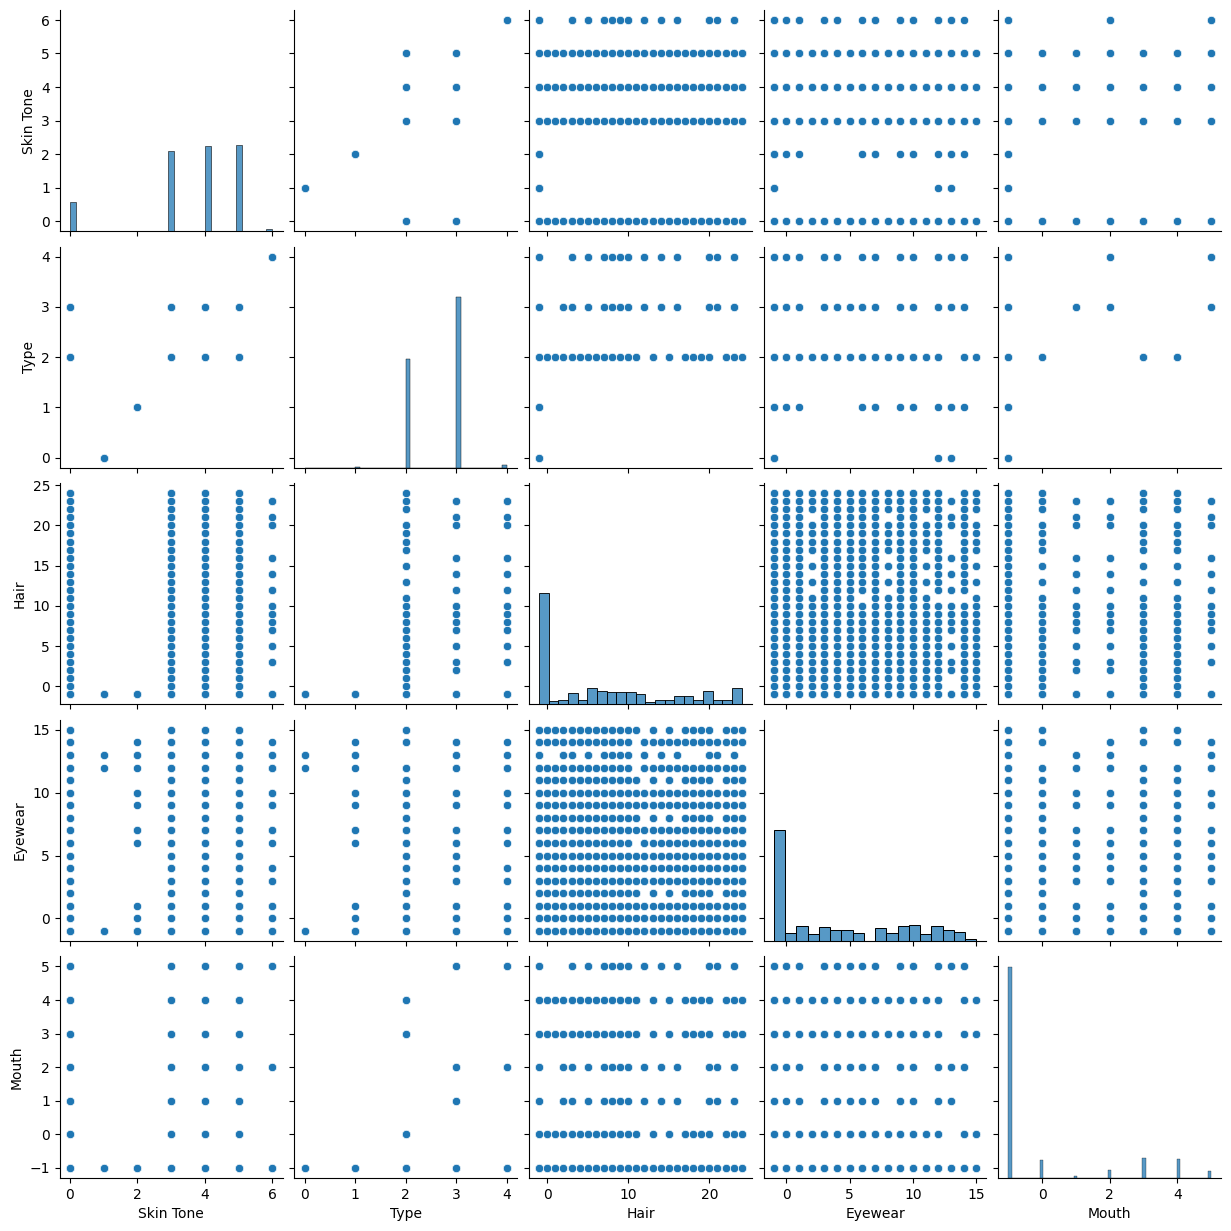

In [36]:
sns.pairplot(t_meta_oh[t_meta_columns[0:5]])

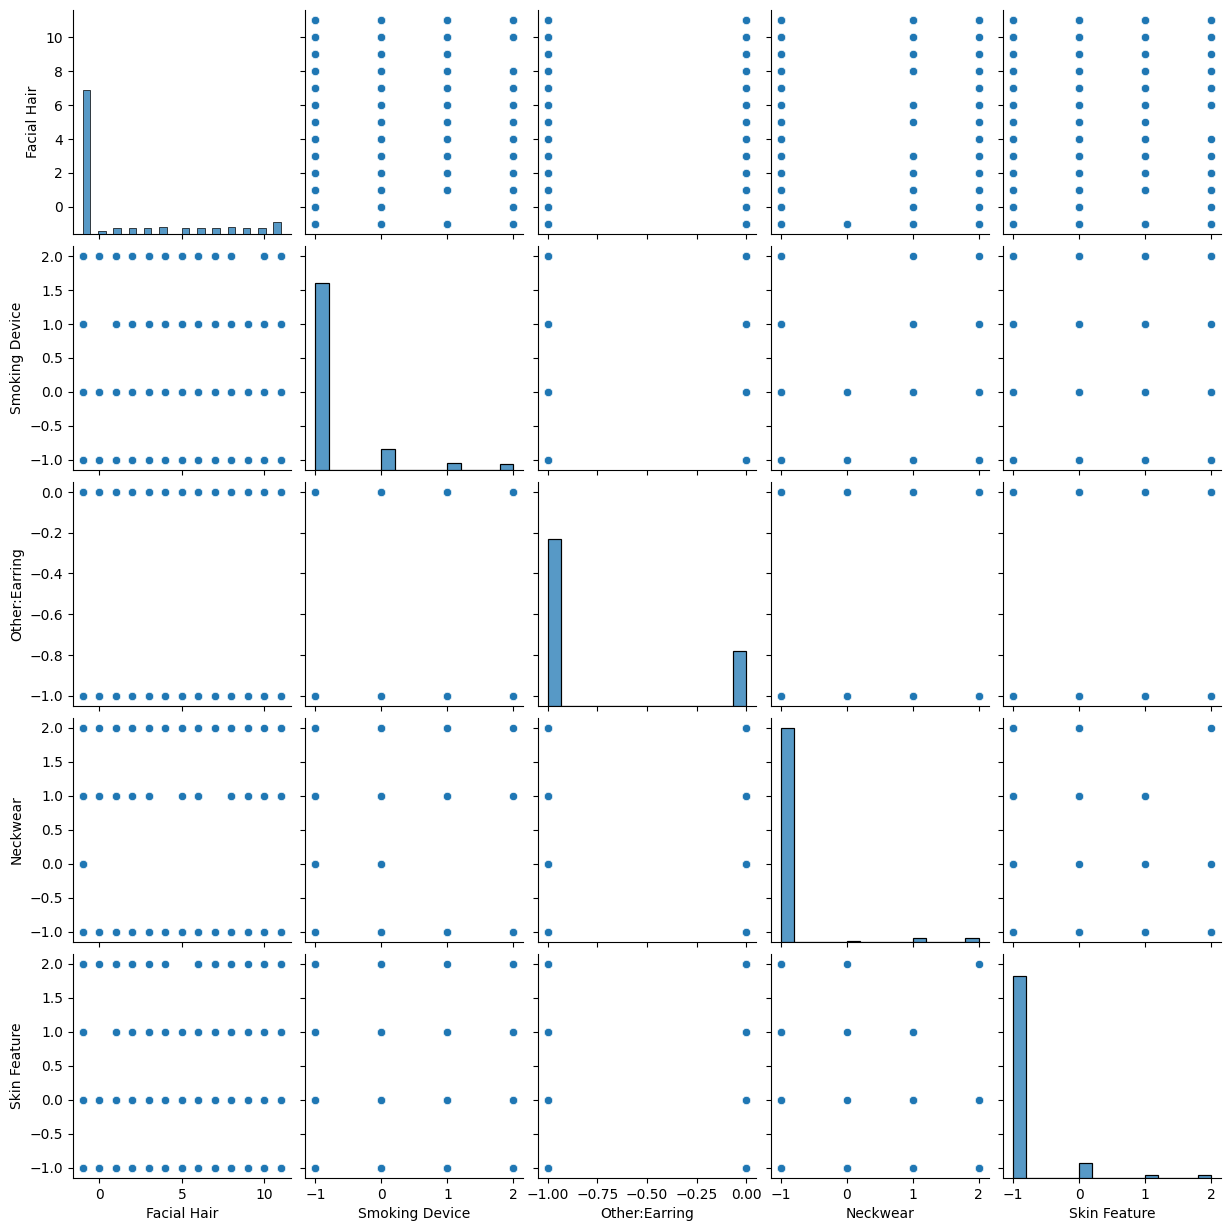

In [37]:
sns.pairplot(t_meta_oh[t_meta_columns[6:11]])

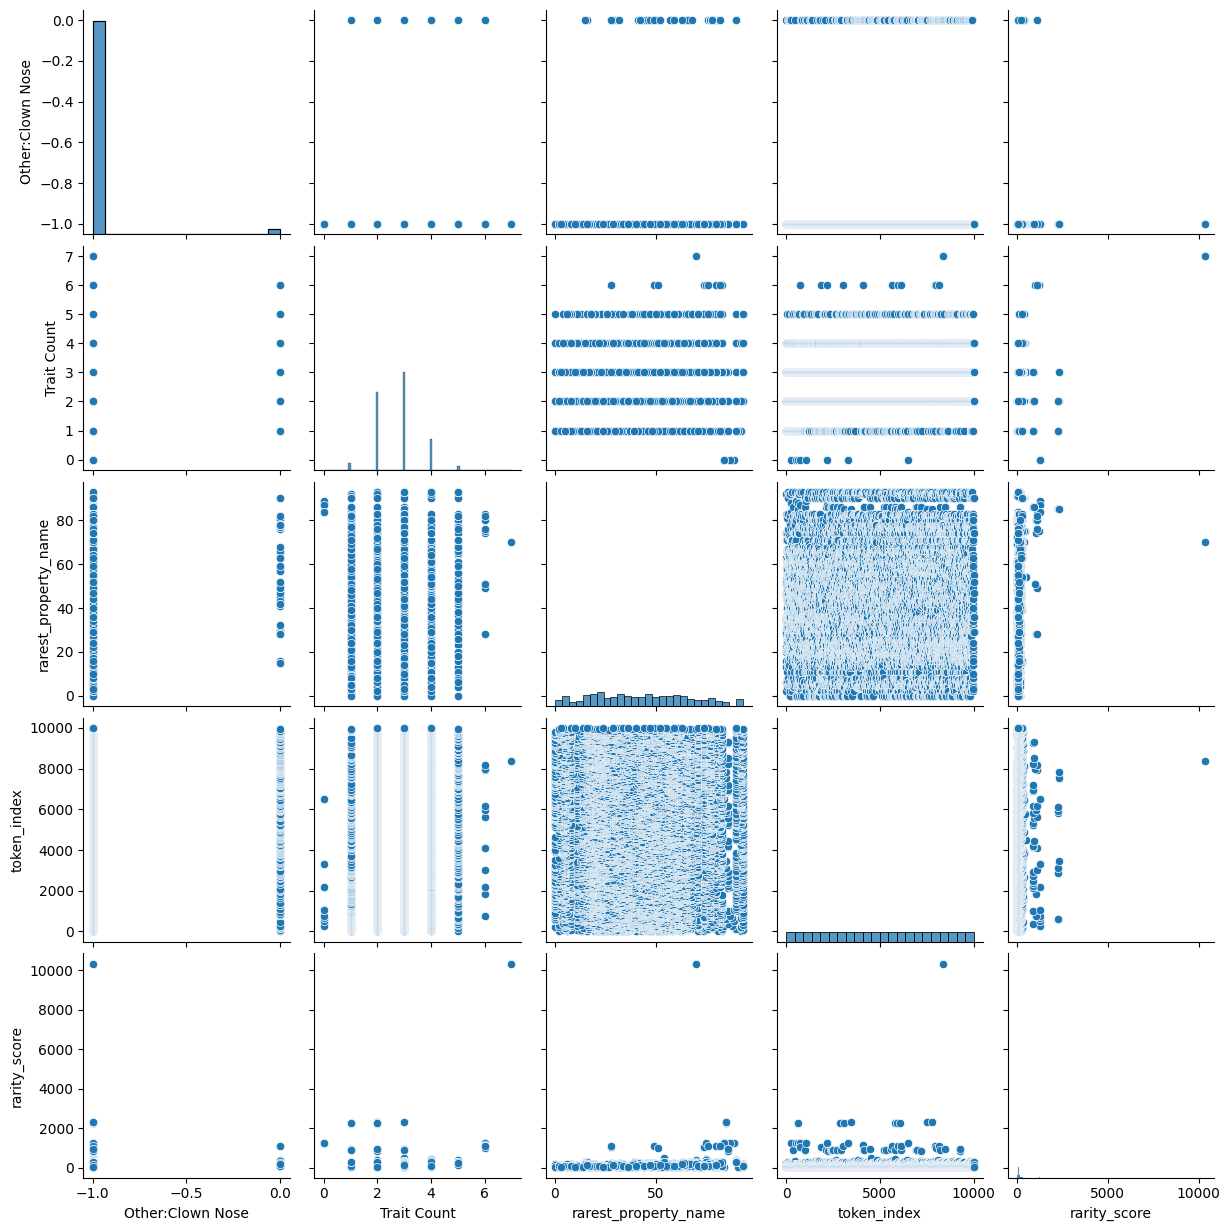

In [38]:
sns.pairplot(t_meta_oh[t_meta_columns[12:]])

<Axes: >

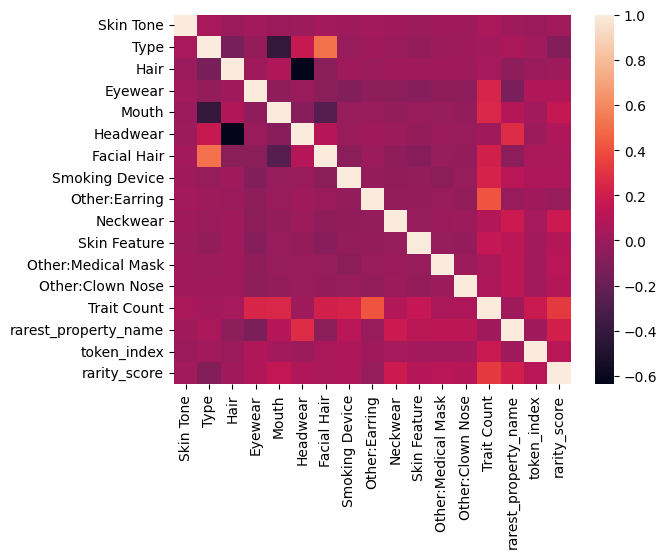

In [39]:
correlation = t_meta_oh.corr(method='kendall')
sns.heatmap(correlation)

In [40]:
t_sales['eth_diff'] = t_sales.sort_values(['token_index','timestamp']).groupby('token_index')['eth'].diff()
y = t_sales.sort_values(['token_index','timestamp']).groupby('token_index')['eth'].mean()

In [41]:
t_sales.sort_values(['token_index','timestamp'],inplace=True)
t_sales

,token_index,timestamp,eth,usd,eth_diff
13,0,1498258589,0.980000,320.313000,NaN
377,0,1499452752,1.600000,394.544000,0.620000
1928,0,1543563155,25.000000,2936.500000,23.400000
65,1,1498512206,0.420000,102.740400,NaN
2194,1,1554528111,31.000000,5118.720000,30.580000
...,...,...,...,...,...
12781,9990,1629011920,0.000009,0.027837,-24.499991
5362,9997,1612791877,99.990000,171388.859400,NaN
4807,9998,1609027375,15.000000,9557.700000,NaN
7055,9998,1614801687,38.000000,59987.560000,23.000000


In [42]:
t_meta_moving_average = t_meta_oh.merge(right=y,on='token_index')
t_meta_moving_average.drop(columns='token_index',inplace=True)
t_meta_moving_average

,Skin Tone,Type,Hair,Eyewear,Mouth,Headwear,Facial Hair,Smoking Device,Other:Earring,Neckwear,Skin Feature,Other:Medical Mask,Other:Clown Nose,Trait Count,rarest_property_name,rarity_score,eth
0,5,2,0,8,-1,-1,-1,-1,0,-1,-1,-1,-1,3,28,117.119410,9.193333
1,3,3,8,-1,5,-1,-1,-1,-1,-1,-1,-1,-1,2,74,72.698512,30.473333
2,3,2,-1,-1,3,10,-1,1,-1,-1,-1,-1,-1,3,63,239.465714,1.750000
3,4,3,12,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,40,68.015914,88.800000
4,4,2,17,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,45,93.656590,57.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,5,3,21,12,-1,-1,11,-1,-1,-1,-1,-1,-1,3,49,113.190823,64.000000
6920,3,2,-1,-1,3,10,-1,0,-1,-1,-1,-1,-1,3,63,218.325800,0.300000
6921,0,3,8,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,36,55.655401,12.250004
6922,6,4,-1,-1,-1,3,2,-1,-1,-1,-1,-1,-1,2,90,306.081831,99.990000


Text(0, 0.5, 'Features')

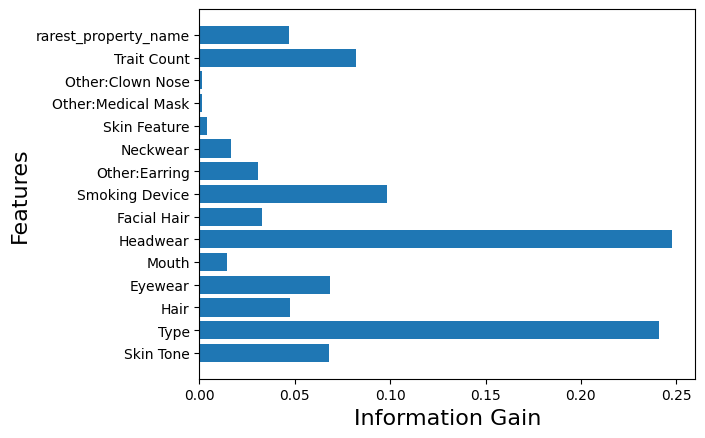

In [43]:
X = t_meta_moving_average[t_meta_moving_average.columns[0:15]].to_numpy()
y = t_meta_moving_average[t_meta_moving_average.columns[16]].to_numpy()
info_gain = ExtraTreesRegressor().fit(X,y)
font_prop = font_manager.FontProperties(size=16)
plt.barh(t_meta_moving_average.columns[0:15],info_gain.feature_importances_)
plt.xlabel("Information Gain", fontproperties=font_prop)
plt.ylabel("Features",fontproperties=font_prop)


In [44]:
(t_metadata.isna().sum()*100)/len(t_metadata)

Skin Tone                0.00
Type                     0.00
Hair                    37.88
Eyewear                 39.28
Mouth                   74.55
Headwear                64.58
Facial Hair             64.97
Smoking Device          84.50
Other:Earring           75.41
Neckwear                96.27
Skin Feature            91.04
Other:Medical Mask      98.25
Other:Clown Nose        97.88
Trait Count              0.00
rarest_property_name     0.00
token_index              0.00
rarity_score             0.00
dtype: float64

Text(0, 0.5, 'Features')

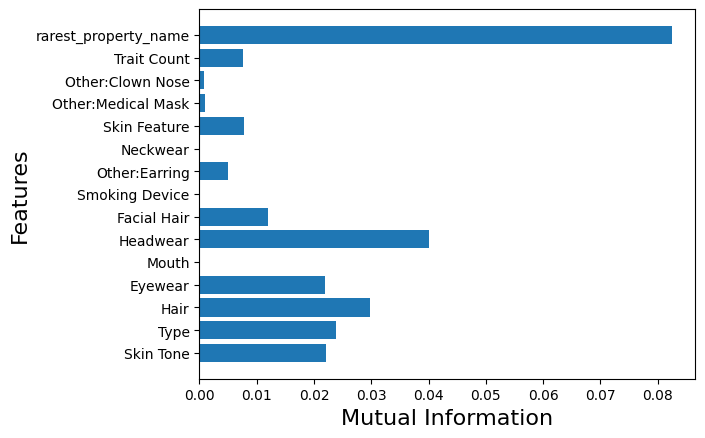

In [45]:
mut_info = mutual_info_regression(X,y)
font_prop = font_manager.FontProperties(size=16)
plt.barh(t_meta_moving_average.columns[0:15],mut_info)
plt.xlabel("Mutual Information", fontproperties=font_prop)
plt.ylabel("Features",fontproperties=font_prop)


In [46]:
open_prices = t_sales.groupby('token_index').first(min_count=2)
open_prices

,timestamp,eth,usd,eth_diff
token_index,,,,
0,1.498259e+09,0.98,320.3130,0.62
1,1.498512e+09,0.42,102.7404,30.58
14,1.499986e+09,0.90,184.8690,0.95
33,NaN,NaN,NaN,NaN
53,1.612211e+09,20.00,26738.6000,2.00
...,...,...,...,...
9987,NaN,NaN,NaN,NaN
9989,NaN,NaN,NaN,NaN
9990,1.616239e+09,24.50,45134.8800,NaN


In [47]:
data_ = t_sales.groupby('token_index').filter(lambda x: len(x)>=2)#.drop(columns=['log_rarity_score'])#,'Skin Feature','Other:Medical Mask','Other:Clown Nose'])
opening_prices = data_.groupby('token_index').first()
closing_prices = data_.groupby('token_index').last()
op_data = opening_prices.merge(right=t_meta_oh,how='left',on='token_index').sort_values('token_index').drop(columns=['token_index','timestamp','eth_diff'])
op_data.rename(columns={'eth':'opening_prices'},inplace=True)
c_p = closing_prices.sort_values('token_index').drop(columns=['timestamp','usd','eth_diff'])
X_train, X_test, y_train, y_test = train_test_split(op_data,c_p,test_size=0.4)

In [48]:
X_train

,opening_prices,usd,Skin Tone,Type,Hair,Eyewear,Mouth,Headwear,Facial Hair,Smoking Device,Other:Earring,Neckwear,Skin Feature,Other:Medical Mask,Other:Clown Nose,Trait Count,rarest_property_name,rarity_score
3906,43.50,69672.2100,4,3,-1,-1,5,4,-1,-1,-1,-1,-1,-1,-1,2,57,120.230914
3990,0.12,69.8952,5,3,-1,0,-1,3,-1,-1,-1,-1,-1,-1,-1,2,56,82.099247
3618,210.00,137739.0000,3,3,-1,-1,2,9,6,-1,0,1,-1,-1,-1,5,76,225.821795
2687,0.37,82.9910,5,3,-1,-1,-1,3,1,-1,0,-1,-1,-1,-1,3,56,86.074638
1725,95.00,197309.3000,5,2,11,8,4,-1,-1,-1,-1,-1,-1,-1,-1,3,39,207.351504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,0.25,56.6400,4,3,8,-1,-1,-1,11,-1,-1,-1,-1,-1,0,3,78,96.061267
3592,169.00,300448.2000,0,3,-1,0,5,2,-1,-1,-1,-1,-1,-1,-1,3,74,119.172685
3834,23.00,51789.3300,4,3,23,13,-1,-1,11,-1,-1,-1,-1,-1,-1,3,13,75.042110
2807,0.25,45.0350,3,3,-1,-1,-1,6,1,-1,-1,2,-1,-1,-1,3,77,160.745706


In [49]:
reg = LinearRegression().fit(X_train,y_train)
reg.score(X_train,y_train)
predicted = reg.predict(X_test)
errors = mean_squared_error(y_test,predicted)
print('Mean Absolute Error:', mean_absolute_error(y_test, predicted))
print('Mean Squared Error:', mean_squared_error(y_test, predicted))
print('Root Mean Squared Error:', mean_squared_error(y_test, predicted, squared=False))

# Print the coefficients and intercept
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)


Mean Absolute Error: 74.98785325639895
Mean Squared Error: 224291.84204873577
Root Mean Squared Error: 473.59459672671073
Coefficients: [[ 2.14721508e-01  1.30521000e-04 -6.40565162e-02  1.24111751e+01
  -1.25405508e+00 -1.07457931e+00 -4.57053148e+00 -2.92988272e+00
  -5.21675185e-01 -8.38650700e+00  2.64040581e+01 -2.97523131e+01
  -2.75464686e+01 -7.29255631e+01 -6.84161636e+01 -4.85239687e+01
  -1.40439301e-01  1.96440065e+00]]
Intercept: [-180.83164568]


/home/maryanne/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


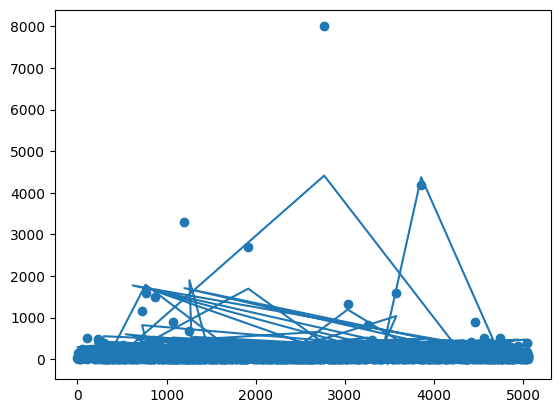

In [50]:
plt.scatter(X_train.index,y_train)
plt.plot(X_train.index,reg.predict(X_train))

In [51]:
data_ = t_sales.groupby('token_index').filter(lambda x: len(x)>=2)
opening_prices = data_.groupby('token_index').first()
closing_prices = data_.groupby('token_index').last()
op_data = opening_prices.merge(right=t_meta_oh,how='left',on='token_index').sort_values('token_index').drop(columns=['token_index','timestamp','eth_diff','Skin Feature','Other:Medical Mask','Other:Clown Nose','Neckwear'])
op_data.rename(columns={'eth':'opening_prices'},inplace=True)
c_p = closing_prices.sort_values('token_index').drop(columns=['timestamp', 'usd','eth_diff'])
X_train, X_test, y_train, y_test = train_test_split(op_data,c_p,test_size=0.4)
reg = LinearRegression().fit(X_train,y_train)
reg.score(X_train,y_train)
predicted = reg.predict(X_test)
#errors = mean_squared_error(y_test,predicted)
print('Mean Absolute Error:', mean_absolute_error(y_test, predicted))
print('Mean Squared Error:', mean_squared_error(y_test, predicted))
print('Root Mean Squared Error:', mean_squared_error(y_test, predicted, squared=False))

# Print the coefficients and intercept
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

Mean Absolute Error: 55.40949258937948
Mean Squared Error: 9421.8950110129
Root Mean Squared Error: 97.06644637058112
Coefficients: [[ 1.14303131e+00 -1.37093066e-04 -4.42712731e+00 -7.17334612e+01
  -1.79259923e+00  1.15138015e+00 -7.73797873e+00 -2.60590301e+00
   5.63961671e+00  2.04676809e+00  2.30754576e+01 -3.86739533e+01
   1.02171226e+00  3.30016084e-01]]
Intercept: [317.11260425]


/home/maryanne/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [52]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Attention and Normalization
#     x = keras.layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(inputs, inputs)
#     x = keras.layers.Dropout(dropout)(x)
#     x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
#     x = keras.layers.Dropout(dropout)(x)
#     x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
#     return x + res

# t_metadata